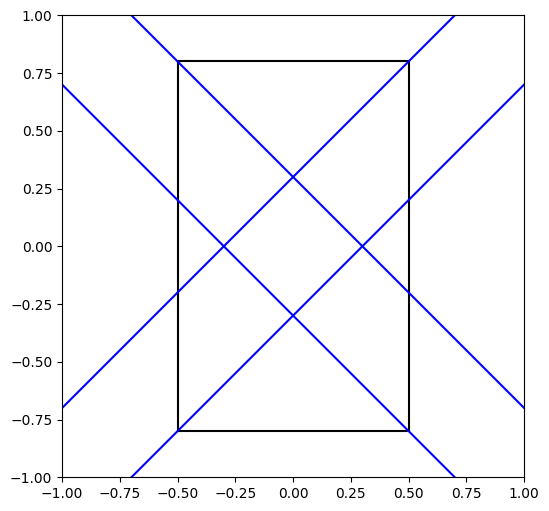

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# define simple counterclockwise polygon going around a rectangle
polygon = np.array([[-0.5, -0.8], [-0.5, 0.8], [0.5, 0.8], [0.5, -0.8], [-0.5, -0.8]])

# calculate the normal of each edge vectorized
edges = polygon[1:] - polygon[:-1]
edge_normals = np.column_stack([edges[:, 1], -edges[:, 0]])
edge_normals /= np.linalg.norm(edge_normals, axis=1, keepdims=True)

# calculate the normal of each vertex vectorized pointing inwards
vertex_normals = edge_normals + np.roll(edge_normals, 1, axis=0)
vertex_normals /= np.linalg.norm(vertex_normals, axis=1, keepdims=True)

# plot the polygon and the normals of edges and vertices
plt.figure(figsize=(6, 6))
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')

plt.plot(polygon[:, 0], polygon[:, 1], 'k-')

# plot vertex normals as blue lines extending through entire domain (vectorized)
v = polygon[:-1]  # vertices (N, 2)
n = vertex_normals  # normals (N, 2)

# calculate t values for all boundaries at once
t_x_neg = np.where(n[:, 0] != 0, (-1 - v[:, 0]) / n[:, 0], np.inf)
t_x_pos = np.where(n[:, 0] != 0, (1 - v[:, 0]) / n[:, 0], np.inf)
t_y_neg = np.where(n[:, 1] != 0, (-1 - v[:, 1]) / n[:, 1], np.inf)
t_y_pos = np.where(n[:, 1] != 0, (1 - v[:, 1]) / n[:, 1], np.inf)

# calculate intersection points for all boundaries
p_x_neg = v + t_x_neg[:, None] * n
p_x_pos = v + t_x_pos[:, None] * n
p_y_neg = v + t_y_neg[:, None] * n
p_y_pos = v + t_y_pos[:, None] * n

# check validity (within domain bounds)
valid_x_neg = (p_x_neg[:, 1] >= -1) & (p_x_neg[:, 1] <= 1) & np.isfinite(t_x_neg)
valid_x_pos = (p_x_pos[:, 1] >= -1) & (p_x_pos[:, 1] <= 1) & np.isfinite(t_x_pos)
valid_y_neg = (p_y_neg[:, 0] >= -1) & (p_y_neg[:, 0] <= 1) & np.isfinite(t_y_neg)
valid_y_pos = (p_y_pos[:, 0] >= -1) & (p_y_pos[:, 0] <= 1) & np.isfinite(t_y_pos)

# stack all t values and points (N, 4) for 4 boundaries
t_all = np.stack([t_x_neg, t_x_pos, t_y_neg, t_y_pos], axis=1)
p_all = np.stack([p_x_neg, p_x_pos, p_y_neg, p_y_pos], axis=1)
valid_all = np.stack([valid_x_neg, valid_x_pos, valid_y_neg, valid_y_pos], axis=1)

# mask invalid intersections with inf/-inf
t_masked = np.where(valid_all, t_all, np.where(t_all > 0, np.inf, -np.inf))

# find min positive and max negative t for each vertex
t_pos_min = np.min(np.where(t_masked > 0, t_masked, np.inf), axis=1)
t_neg_max = np.max(np.where(t_masked < 0, t_masked, -np.inf), axis=1)

# get corresponding points
idx_pos = np.argmin(np.where(t_masked > 0, t_masked, np.inf), axis=1)
idx_neg = np.argmax(np.where(t_masked < 0, t_masked, -np.inf), axis=1)
p_pos = p_all[np.arange(len(v)), idx_pos]
p_neg = p_all[np.arange(len(v)), idx_neg]

# plot lines where both intersections exist
valid_lines = np.isfinite(t_pos_min) & np.isfinite(t_neg_max)
for i in np.where(valid_lines)[0]:
    plt.plot([p_neg[i, 0], p_pos[i, 0]], [p_neg[i, 1], p_pos[i, 1]], 'b-')

plt.show()




Found 4 intersections


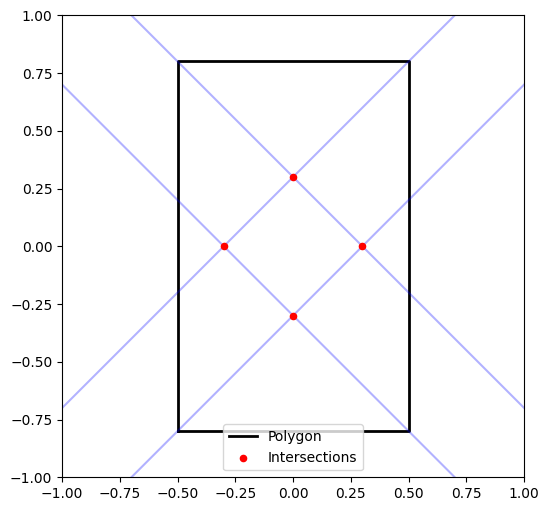

In [ ]:
# calculate all line-line intersections
n_lines = len(p_pos)
d_i = p_pos - p_neg  # direction vectors (N, 2)
intersections_all = []

# find all pairwise intersections
for i in range(n_lines):
    for j in range(i + 1, n_lines):
        # solve: p_neg[i] + s * d_i[i] = p_neg[j] + t * d_i[j]
        # rearrange: s * d_i[i] - t * d_i[j] = p_neg[j] - p_neg[i]
        A = np.column_stack([d_i[i], -d_i[j]])
        b = p_neg[j] - p_neg[i]
        
        # check if lines are not parallel
        det = A[0, 0] * A[1, 1] - A[0, 1] * A[1, 0]
        if abs(det) > 1e-10:
            # solve for s, t
            st = np.linalg.solve(A, b)
            # intersection point
            point = p_neg[i] + st[0] * d_i[i]
            intersections_all.append(point)

intersections_all = np.array(intersections_all)
print(f"Found {len(intersections_all)} intersections")

# plot everything
plt.figure(figsize=(6, 6))
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')

plt.plot(polygon[:, 0], polygon[:, 1], 'k-', linewidth=2, label='Polygon')

# plot the lines
for i in np.where(valid_lines)[0]:
    plt.plot([p_neg[i, 0], p_pos[i, 0]], [p_neg[i, 1], p_pos[i, 1]], 'b-', alpha=0.3)

# plot intersections
if len(intersections_all) > 0:
    plt.scatter(intersections_all[:, 0], intersections_all[:, 1], c='r', s=20, zorder=5, label='Intersections')

plt.legend()
plt.show()


Found 8 collisions


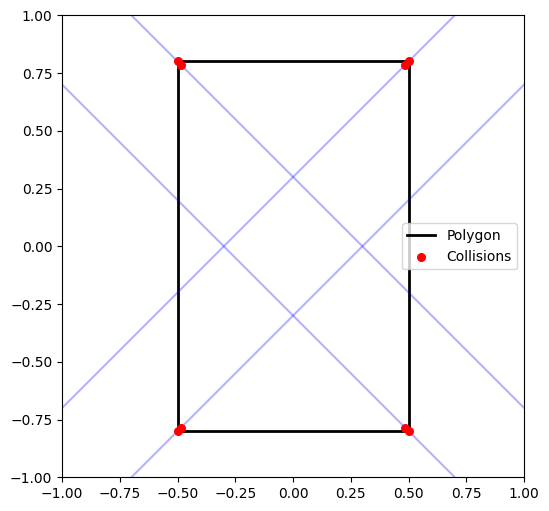

In [17]:
# ray marching with spatial hashing
step_size = 0.01
grid_size = 0.02  # hash grid resolution

# hash function for 2D points
def hash_point(p, grid_size):
    return (int(p[0] / grid_size), int(p[1] / grid_size))

# store which ray hit which hash cell
hash_table = {}  # hash -> list of (ray_id, point)
collision_points = []

# march rays from each vertex in both directions
n_vertices = len(polygon) - 1
for i in range(n_vertices):
    v = polygon[i]
    n = vertex_normals[i]
    
    # ray in positive direction
    for direction, ray_id in [(1, i*2), (-1, i*2+1)]:
        pos = v.copy()
        while -1 <= pos[0] <= 1 and -1 <= pos[1] <= 1:
            h = hash_point(pos, grid_size)
            
            if h in hash_table:
                # collision detected
                collision_points.append(pos.copy())
                break
            else:
                hash_table[h] = (ray_id, pos.copy())
            
            pos += direction * step_size * n

collision_points = np.array(collision_points) if collision_points else np.array([]).reshape(0, 2)
print(f"Found {len(collision_points)} collisions")

# visualize
plt.figure(figsize=(6, 6))
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')

plt.plot(polygon[:, 0], polygon[:, 1], 'k-', linewidth=2, label='Polygon')

# plot the lines
for i in range(n_vertices):
    plt.plot([p_neg[i, 0], p_pos[i, 0]], [p_neg[i, 1], p_pos[i, 1]], 'b-', alpha=0.3)

# plot collision points
if len(collision_points) > 0:
    plt.scatter(collision_points[:, 0], collision_points[:, 1], c='r', s=30, zorder=5, label='Collisions')

plt.legend()
plt.show()

In [20]:
# robust intersection calculation for each line
n_lines = len(p_pos)
d = p_pos - p_neg  # direction vectors

# for each line, collect all intersection points
line_intersections = []

for i in range(n_lines):
    intersections = []
    
    # add boundary intersections (already calculated)
    intersections.append((0.0, p_neg[i]))  # start at negative boundary
    intersections.append((1.0, p_pos[i]))  # end at positive boundary
    
    # find intersections with other lines
    for j in range(n_lines):
        if i == j:
            continue
        
        # solve: p_neg[i] + s * d[i] = p_neg[j] + t * d[j]
        A = np.column_stack([d[i], -d[j]])
        b = p_neg[j] - p_neg[i]
        
        det = A[0, 0] * A[1, 1] - A[0, 1] * A[1, 0]
        if abs(det) > 1e-10:
            st = np.linalg.solve(A, b)
            s, t = st[0], st[1]
            
            # check if intersection is within both line segments
            if 0 <= s <= 1 and 0 <= t <= 1:
                point = p_neg[i] + s * d[i]
                intersections.append((s, point))
    
    # sort by parameter s along the line
    intersections.sort(key=lambda x: x[0])
    line_intersections.append(intersections)

print(f"Processed {n_lines} lines with intersections")


Processed 4 lines with intersections


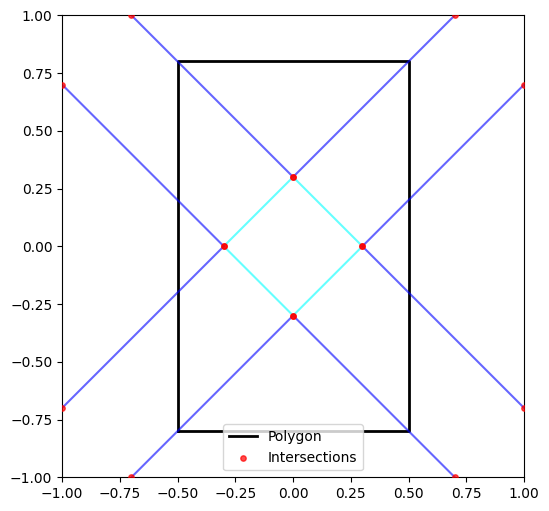

In [21]:
# draw segments between consecutive intersections
plt.figure(figsize=(6, 6))
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')

plt.plot(polygon[:, 0], polygon[:, 1], 'k-', linewidth=2, label='Polygon')

# draw each segment
for i, intersections in enumerate(line_intersections):
    for k in range(len(intersections) - 1):
        p1 = intersections[k][1]
        p2 = intersections[k+1][1]
        # alternate colors for consecutive segments
        color = 'blue' if k % 2 == 0 else 'cyan'
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color=color, linewidth=1.5, alpha=0.6)

# draw intersection points
all_points = []
for intersections in line_intersections:
    for _, point in intersections:
        all_points.append(point)
all_points = np.array(all_points)
plt.scatter(all_points[:, 0], all_points[:, 1], c='red', s=15, zorder=5, alpha=0.7, label='Intersections')

plt.legend()
plt.show()
